In [1]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
!pip install textblob
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter

!pip install wordcloud
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('amazon_alexa.tsv',sep='\t')
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [23]:
data.shape

(3150, 6)

In [3]:
# Creating a new column sentiment based on overall ratings
def sentiments(df):
  if df['rating'] > 3.0:
    return 'Positive'
  elif df['rating'] <= 3.0:
    return 'Negative'

data['sentiment'] = data.apply(sentiments, axis=1)

In [4]:
data.head()

,rating,date,variation,verified_reviews,feedback,sentiment
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,Positive
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,Positive
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,Positive
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,Positive
4,5,31-Jul-18,Charcoal Fabric,Music,1,Positive


In [5]:
#Check if there are any null values
data_v1 = data[['verified_reviews','sentiment']]
data_v1.isnull().sum()

verified_reviews    0
sentiment           0
dtype: int64

In [6]:
def cleaning(df, stop_words):

    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: 
    ' '.join(x.lower() for x in x.split()))

    # Replacing the special characters

    #df['verified_reviews'] = df['verified_reviews'].str.replace('[^ws]', '')

    # Replacing the digits/numbers

    df['verified_reviews'] = df['verified_reviews'].str.replace('d', '')

    # Removing stop words

    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: 

            ' '.join(x for x in x.split() if x not in stop_words))

    # Lemmatization

    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: 

            ' '.join([Word(x).lemmatize() for x in x.split()]))

    return df

stop_words = stopwords.words('english')

data_v1 = cleaning(data_v1, stop_words)

<ipython-input-6-c9736531f9b2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['verified_reviews'] = df['verified_reviews'].apply(lambda x:
<ipython-input-6-c9736531f9b2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['verified_reviews'] = df['verified_reviews'].str.replace('d', '')
<ipython-input-6-c9736531f9b2>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [7]:
data_v1.head()

,verified_reviews,sentiment
0,love echo!,Positive
1,love it!,Positive
2,"sometimes playing game, answer question correc...",Positive
3,"ha lot fun thing. 4 yr ol learns inosaurs, con...",Positive
4,music,Positive


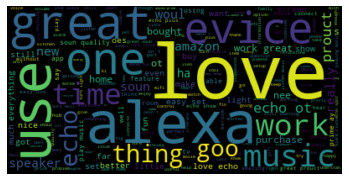

In [8]:
common_words=''
for i in data_v1.verified_reviews:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [9]:
# Encoded the target column
lb=LabelEncoder()
data_v1['sentiment'] = lb.fit_transform(data_v1['sentiment'])

<ipython-input-9-3c303bced4a2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_v1['sentiment'] = lb.fit_transform(data_v1['sentiment'])


In [10]:
data_v1.head()

,verified_reviews,sentiment
0,love echo!,1
1,love it!,1
2,"sometimes playing game, answer question correc...",1
3,"ha lot fun thing. 4 yr ol learns inosaurs, con...",1
4,music,1


In [11]:
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(data_v1['verified_reviews'].values)
X = tokenizer.texts_to_sequences(data['verified_reviews'].values)
X = pad_sequences(X)

In [30]:
model = Sequential()
model.add(Embedding(500, 100, input_length = X.shape[1]))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 319, 100)          50000     
_________________________________________________________________
lstm_7 (LSTM)                (None, 176)               195008    
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 354       
Total params: 245,362
Trainable params: 245,362
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
#Splitting the data into training and testing
y=pd.get_dummies(data_v1['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [14]:
batch_size=32
model.fit(X_train, y_train, epochs = 5, batch_size=batch_size, verbose = 'auto')

Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


In [15]:
model.evaluate(X_test,y_test)

30/30 [==============================] - 6s 186ms/step - loss: 0.2621 - accuracy: 0.8889


[0.2620922327041626, 0.8888888955116272]

In [21]:
import numpy as np
y =['I love this product']
tokenizer.fit_on_texts(y)
y = tokenizer.texts_to_sequences(y)
y = pad_sequences(y)
out = np.argmax(model.predict(y))

if out==1:
    print('Positive')
else:
    print('Negative')


Positive


In [22]:
out

1